# Exploratory Data Analysis on Educational Data

In this notebook, we explore the performance of public school students in the city of Natal in Brazil. The purpose of this exploration is to contain an initial analysis of the possibilities of using machine learning in the data. The data are presented under tuples of students, with their performances and school attendance in the subjects of Portuguese and Mathematics. In addition, the location of the student's residence is provided, which brings more value to the dataset. We add data from the neighborhood where each student lives to enrich the analysis and to observe how important it is in their classroom performance.

### Import dependencies and loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

folder = '/home/adelsondias/Repos/educational-analytics/data/'

In [2]:
students = pd.read_csv(folder+'alunos.csv')
print(students.shape)
students.head()

(65524, 14)


,ID,direc,municipio,escola,etapa,serie,turno,turma,disciplina,frequencia,media_final,situacao,latitude,longitude
0,9599,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º Ano,MATUTINO,EFAFM6A,Língua Portuguesa,92.5,6.9,APROVADO,-5.885477,-35.168400
1,9595,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º Ano,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,6.6,APROVADO,-5.739230,-35.243496
2,9606,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º Ano,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,6.1,APROVADO,-5.736580,-35.242956
3,93948,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º Ano,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,7.6,APROVADO,-5.742527,-35.242607
4,9582,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º Ano,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,7.1,APROVADO,-5.742393,-35.244102


## 0. Preprocessing


### 0.1. Cleaning the data

In [6]:
students['serie'] = students['serie'].apply(lambda x: x.upper())
students = students.loc[students['etapa'].isin(students['etapa'].value_counts()[:5].index)]
students['etapa'] = students['etapa'].replace({'CEJA ENSINO MEDIO': 'EJA - ENSINO MÉDIO'})
students['serie'] = students['serie'].replace({'2º PERÍODO (2ª SÉRIE)':'2ª SÉRIE',
 '3º PERÍODO (3ª SÉRIE)':'3ª SÉRIE',
 '1º PERÍODO (1ª SÉRIE)':'1ª SÉRIE'                                 
})
students['media_final'] = students['media_final'].astype(float)
students['frequencia'] = students['frequencia'].astype(float)

### 0.2. Transforming the dataframe to a geodataframe

In [7]:
students['geometry'] = students.apply(lambda x: shapely.geometry.Point([x['longitude'],x['latitude']]), axis=1)
students = gpd.GeoDataFrame(students)
students.head()

,ID,direc,municipio,escola,etapa,serie,turno,turma,disciplina,frequencia,media_final,situacao,latitude,longitude,geometry
0,9599,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º ANO,MATUTINO,EFAFM6A,Língua Portuguesa,92.5,6.9,APROVADO,-5.885477,-35.168400,POINT (-35.16840029999999 -5.885477)
1,9595,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º ANO,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,6.6,APROVADO,-5.739230,-35.243496,POINT (-35.2434962 -5.739229900000001)
2,9606,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º ANO,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,6.1,APROVADO,-5.736580,-35.242956,POINT (-35.2429557 -5.7365805)
3,93948,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º ANO,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,7.6,APROVADO,-5.742527,-35.242607,POINT (-35.242607 -5.742527099999999)
4,9582,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º ANO,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,7.1,APROVADO,-5.742393,-35.244102,POINT (-35.2441023 -5.742393)


## 1. Exploratory Data Analysis

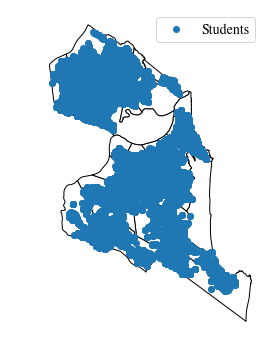

In [16]:
districts = gpd.read_file(folder+'bairros_natal_populacao2016.geojson')
sd = gpd.sjoin(students, districts, op='within')
sd = sd.dropna()

fig, ax = plt.subplots(figsize=(4,6))
districts.plot(ax=ax, color='white', edgecolor='black', label='Districts')
sd.plot(ax=ax, label='Students')
ax.legend(fontsize=14)
ax.axis('off');

## 1.a. Addressing crime deprivation index

### 1.a.1. Aggregating by district

In [17]:
df = pd.DataFrame()
crimes = {}
for i,crimetype in enumerate(['burglary','violent-lethal','drugs']):
    crimes[crimetype] = pd.read_csv(folder+'natal_bairros_{}_dens.csv'.format(crimetype),header=-1)
    crimes[crimetype].columns=['BAIRRO','dens_crimes_bairro_{}'.format(crimetype)]
    crimes[crimetype].set_index('BAIRRO', inplace=True)
    df = pd.concat([df, crimes[crimetype]],axis=1)
crimes = df
crimes.head()

,dens_crimes_bairro_burglary,dens_crimes_bairro_violent-lethal,dens_crimes_bairro_drugs
BAIRRO,,,
Alecrim,1.272815,1.585686,0.362646
Areia Preta,2.400063,4.609644,1.333368
Barro Vermelho,1.874693,0.866237,0.426654
Bom Pastor,0.920760,3.056215,0.665780
Candelária,0.882009,0.502166,0.152903


In [46]:
sd = sd.join(crimes, on='BAIRRO')
sd.head()

ValueError: columns overlap but no suffix specified: Index(['dens_crimes_bairro_burglary', 'dens_crimes_bairro_violent-lethal',
       'dens_crimes_bairro_drugs'],
      dtype='object')

### 1.a.1. Density of crimes around the students

In [16]:
from sklearn.neighbors import KernelDensity

crimes_data = {}
X_ = pd.DataFrame()
for crimetag in ['burglary','violent-lethal','drugs']:
    print(crimetag)
    crimes_data[crimetag] = pd.read_csv(folder+'natal_crimes_{}.csv'.format(crimetag))
    kde = KernelDensity(bandwidth=0.1/69, kernel='exponential', metric='haversine').fit(crimes_data[crimetag][['lon','lat']].sample(frac=0.5))
    X = pd.DataFrame(kde.score_samples(sd[['longitude','latitude']]),
                         index=sd.index, columns=['kde_{}'.format(crimetag)])
    X_ = pd.concat([X_,X],axis=1)

burglary
violent-lethal
drugs


In [20]:
sd = sd.join(X_)

## 1. Predictive Analysis

In [42]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

### 1.1. Approved/Reproved classification

In [48]:
# Features
features = ['frequencia','escola','serie','turno','REG_ADM','populacao2016','densidade2016','dens_crimes_bairro_burglary','dens_crimes_bairro_violent-lethal','dens_crimes_bairro_drugs']
X = sd.copy(deep=True)[features]
for feature in features[1:5]: #'REG_ADM', 'populacao2016','densidade2016'
    X[feature] = LabelEncoder().fit_transform(X[feature]) 

y = LabelEncoder().fit_transform(sd['situacao']) 


# # Model selection
# pgrid = {
#     'n_estimators': [100, 200],
#     'max_depth':[3, 5],
#     'max_features':[0.8, 1]
# }
# clf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=pgrid, cv=5, n_iter=1, n_jobs=-1)
# clf.fit(X,y)
# print('Accuracy:', clf.best_score_)

Accuracy: 0.8008072407045009


## 1.3. Correlogram of features

In [49]:
X['situacao'] = 2-LabelEncoder().fit_transform(sd['situacao']) 
X['media_final'] = sd['media_final']

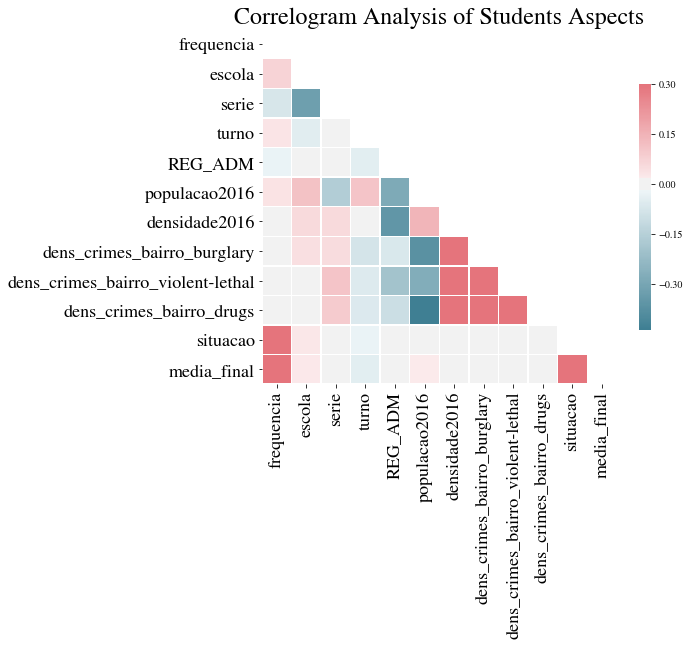

In [50]:
fig, ax = plt.subplots(figsize=(10,10))

corr = X.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.set_title('Correlogram Analysis of Students Aspects',fontsize=24)
plt.tight_layout()
plt.savefig('plots/correlogram_features.pdf',dpi=200)

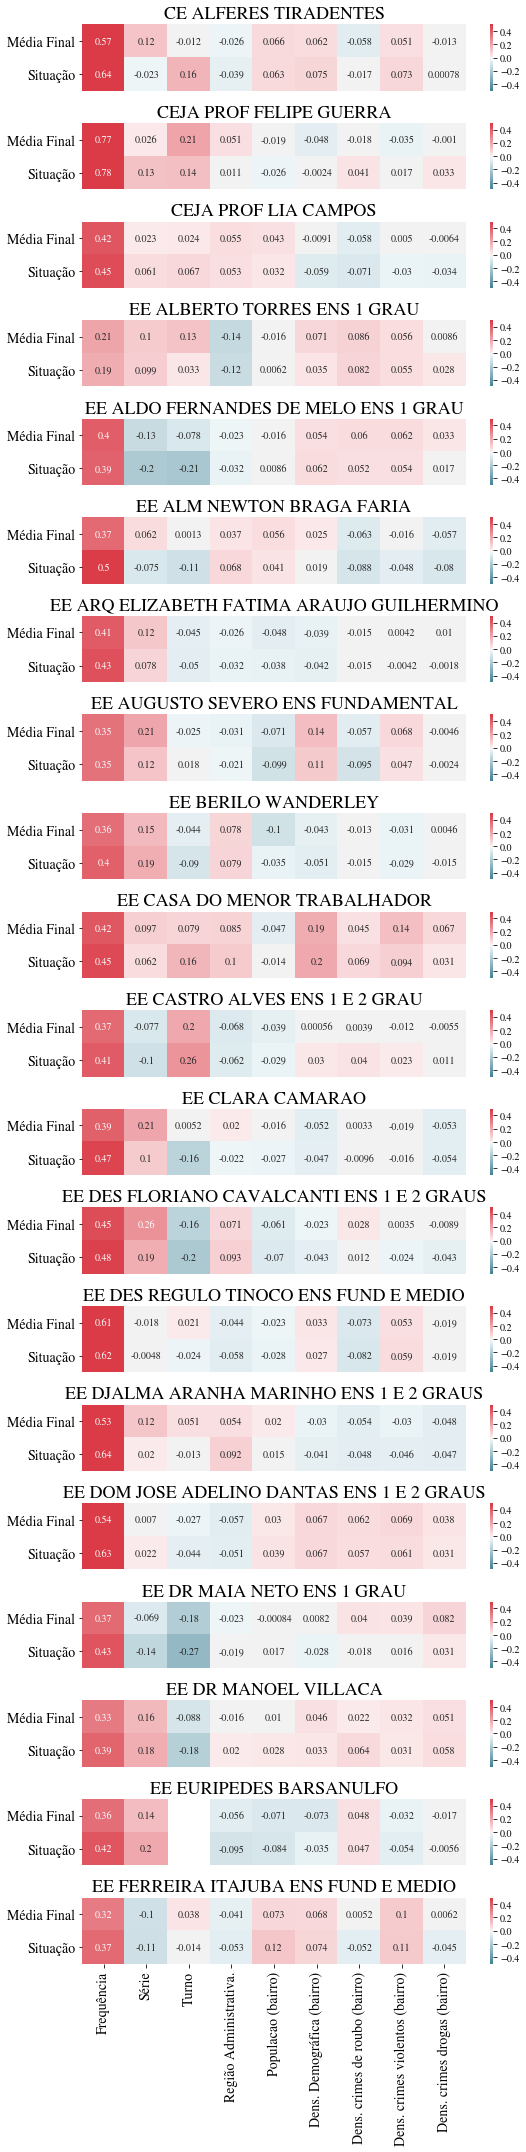

In [93]:
fig, ax = plt.subplots(figsize=(8,30), nrows=20)
X['escola_'] = sd['escola']
for i, school in enumerate(X['escola_'].unique()[:20]):
    features = ['frequencia','serie','turno','REG_ADM','populacao2016','densidade2016','dens_crimes_bairro_burglary','dens_crimes_bairro_violent-lethal','dens_crimes_bairro_drugs']
    if i==19:
        sns.heatmap(X.loc[X['escola_']==school].corr().loc[['situacao','media_final'], features], cmap=cmap, ax=ax[i], vmin=-0.5, vmax=0.5, annot=True)
    else:
        sns.heatmap(X.loc[X['escola_']==school].corr().loc[['situacao','media_final'], features], xticklabels=False, cmap=cmap, ax=ax[i], vmin=-0.5, vmax=0.5, annot=True)
    ax[i].set_yticklabels(['Média Final','Situação'], rotation = 0, ha="right")
    ax[i].yaxis.set_tick_params(labelsize=14)
    ax[i].set_title(school, fontsize=18)
ax[-1].set_xticklabels(['Frequência','Série','Turno','Região Administrativa.','Populacao (bairro)', 'Dens. Demográfica (bairro)', 'Dens. crimes de roubo (bairro)', 'Dens. crimes violentos (bairro)', 'Dens. crimes drogas (bairro)'])
ax[-1].xaxis.set_tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('plots/correlogram_by_school.pdf',dpi=200)